In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx

%matplotlib inline
import matplotlib as mpl
mpl.rcParams['figure.dpi']=75
plt.rcParams['svg.fonttype'] = 'none'
plt.rcParams.update({'font.family':'sans-serif'})
plt.rcParams.update({'font.sans-serif':'Arial'})

In [2]:
params = {
    'figure.figsize': (10, 8),       # Figure size in inches
    'figure.dpi': 300,               # Resolution in dots per inch
    'axes.labelsize': 24,            # Font size of the axes labels
    'axes.titlesize': 24,            # Font size of the subplot titles
    'axes.titlepad': 20,             # Spacing between the subplot title and the plot
    'axes.linewidth': 1.5,           # Width of the axis lines
    'axes.grid': False,              # Display grid lines
    'axes.grid.axis': 'both',        # Display grid lines for both major and minor ticks
    'grid.alpha': 0.5,               # Transparency of the grid lines
    'grid.linewidth': 0.5,           # Width of the grid lines
    'xtick.labelsize': 20,           # Font size of the x-axis tick labels
    'ytick.labelsize': 20,           # Font size of the y-axis tick labels
    'xtick.major.size': 6,           # Length of the major x-axis ticks in points
    'xtick.major.width': 1.5,        # Width of the major x-axis ticks
    'ytick.major.size': 6,           # Length of the major y-axis ticks in points
    'ytick.major.width': 1.5,        # Width of the major y-axis ticks
    'xtick.minor.size': 4,           # Length of the minor x-axis ticks in points
    'xtick.minor.width': 1.0,        # Width of the minor x-axis ticks
    'ytick.minor.size': 4,           # Length of the minor y-axis ticks in points
    'ytick.minor.width': 1.0,        # Width of the minor y-axis ticks
    'xtick.direction': 'in',         # Direction of the x-axis ticks ('in', 'out', or 'inout')
    'ytick.direction': 'in',         # Direction of the y-axis ticks ('in', 'out', or 'inout')
    'legend.fontsize': 18,           # Font size of the legend
    'legend.frameon': True,          # Whether to draw a frame around the legend
    'legend.facecolor': 'inherit',   # Background color of the legend
    'legend.edgecolor': '0.8',       # Edge color of the legend
    'legend.framealpha': 0.8,        # Transparency of the legend frame
    'legend.loc': 'best',            # Location of the legend ('best', 'upper right', 'upper left', 'lower left', etc.)
    'legend.title_fontsize': 20,     # Font size of the legend title
    'text.usetex': False,            # Whether to use LaTeX for text rendering
    'pdf.fonttype': 42               # Output font type for PDF files
}

plt.rcParams.update(params)
plt.style.use('seaborn-colorblind')

/var/folders/c2/p6l4gf2935z26c2jq5cy44b00000gn/T/ipykernel_53132/941554247.py:36: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-colorblind')


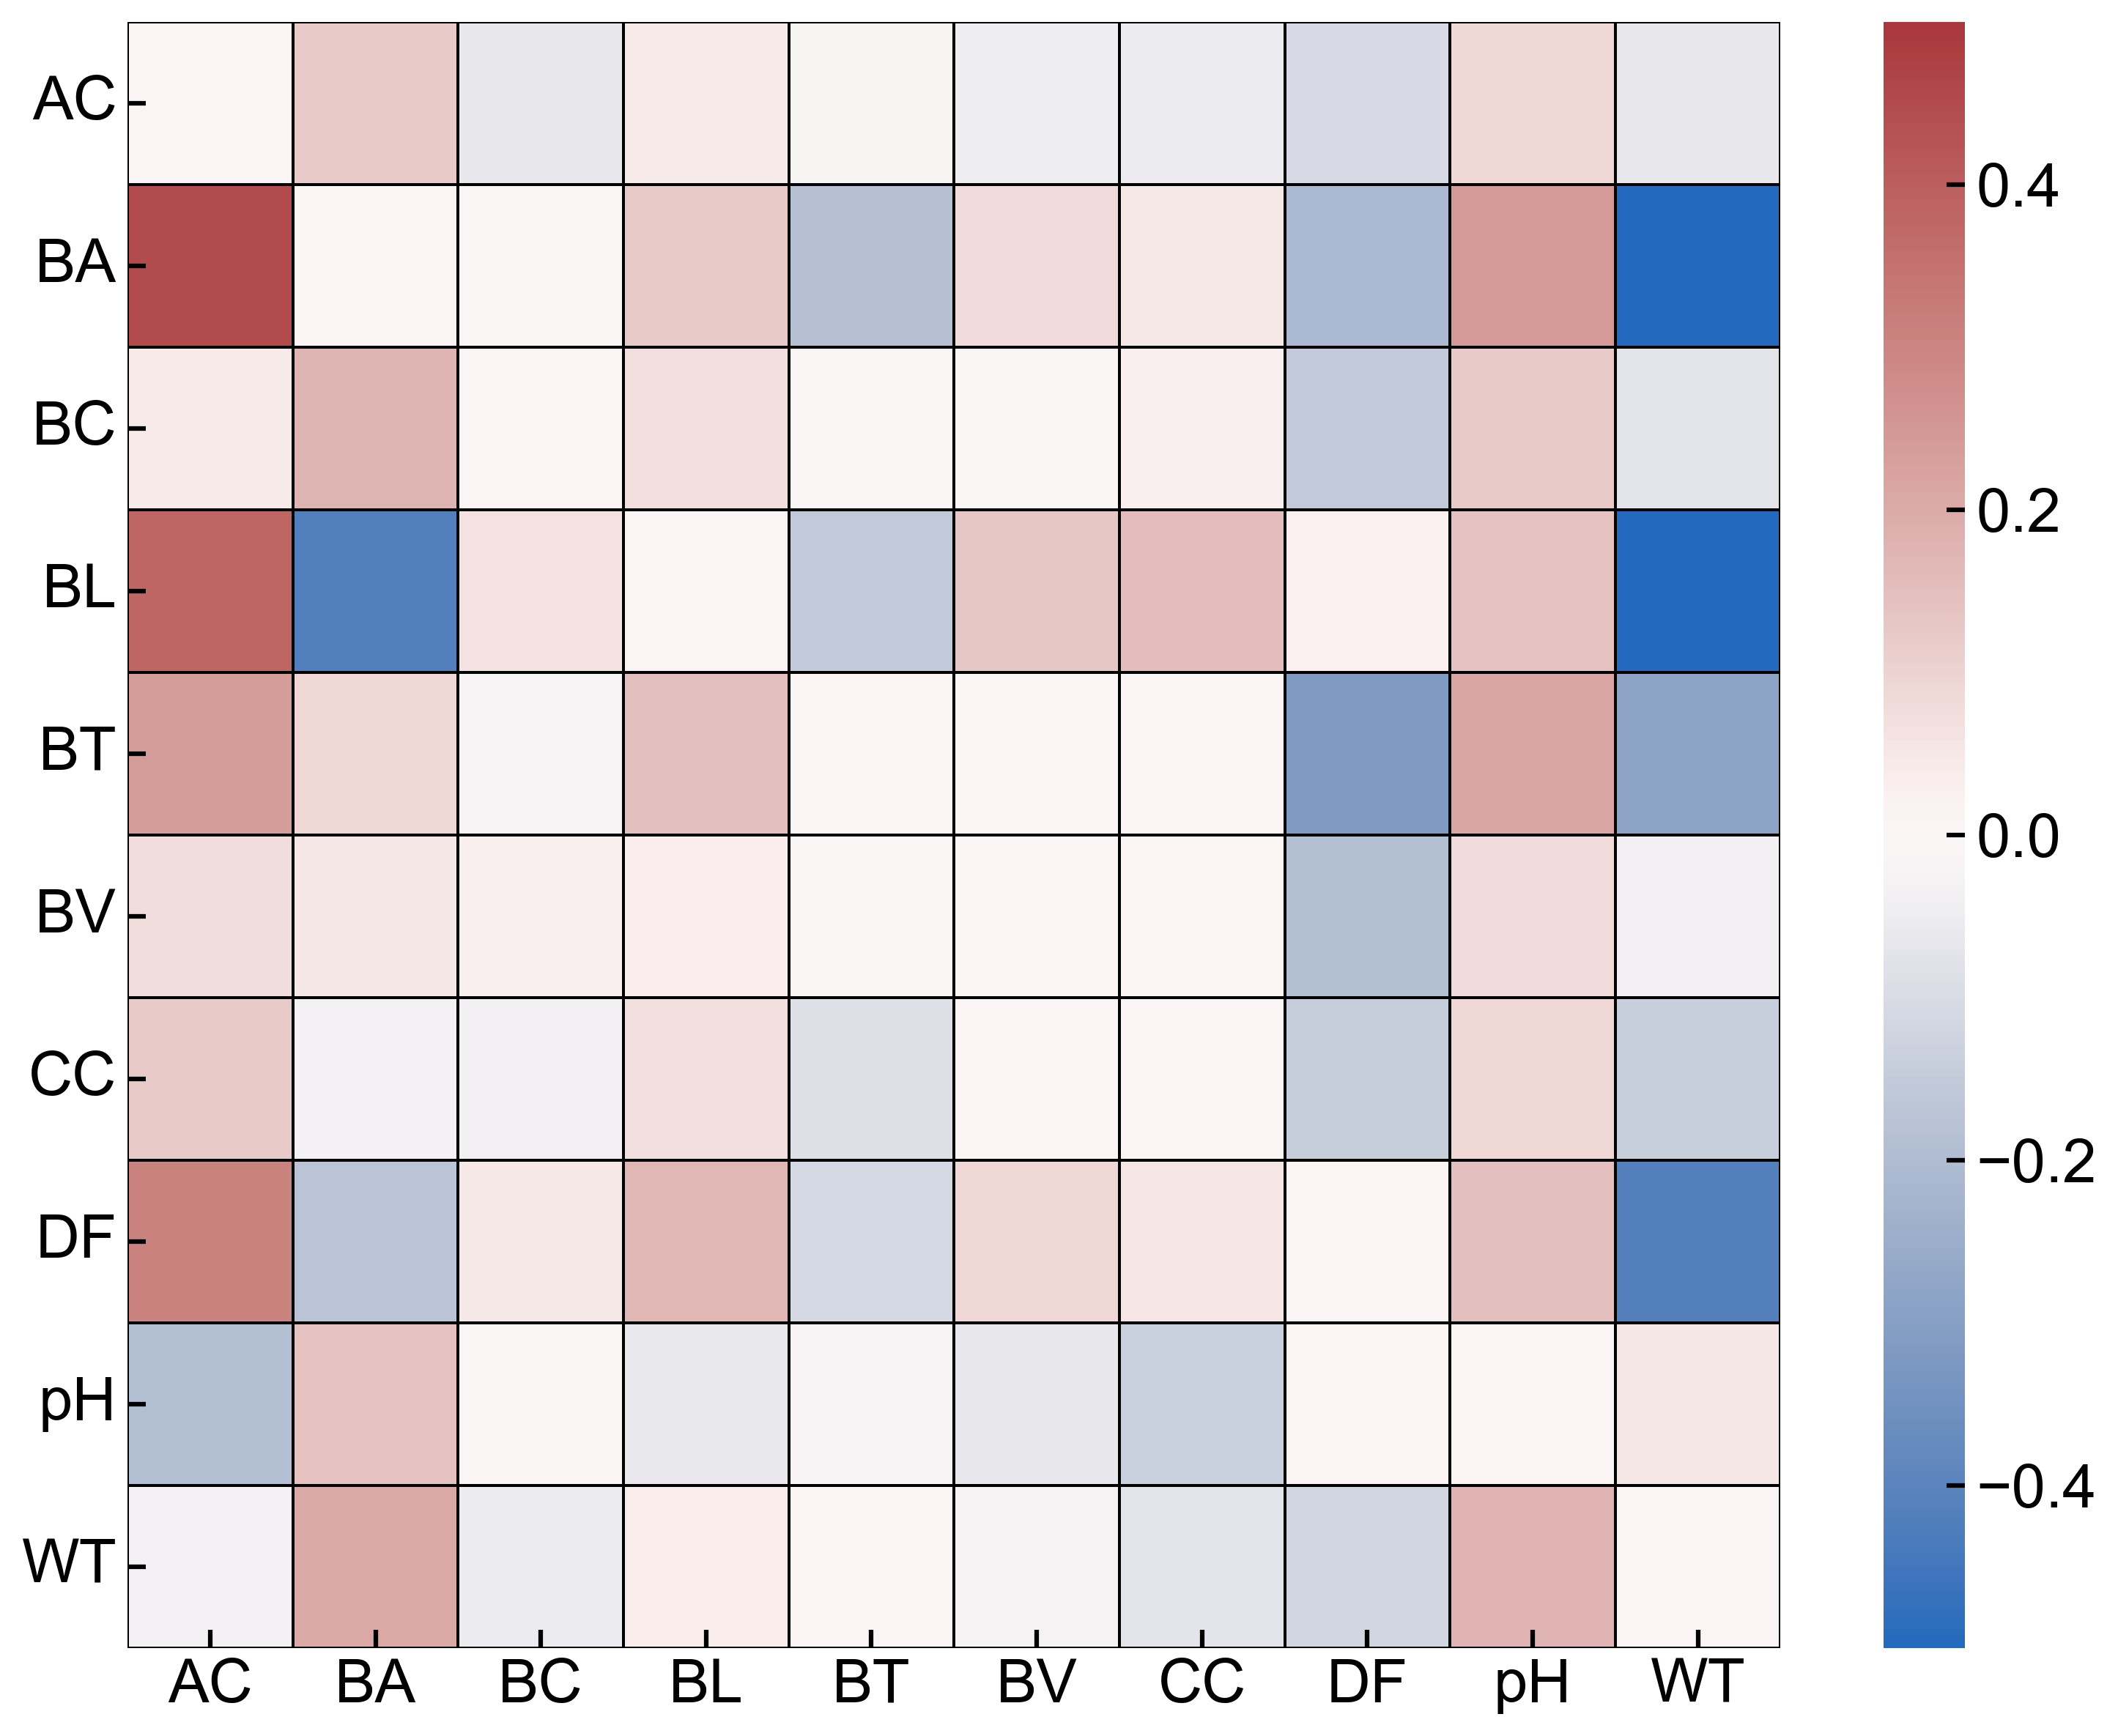

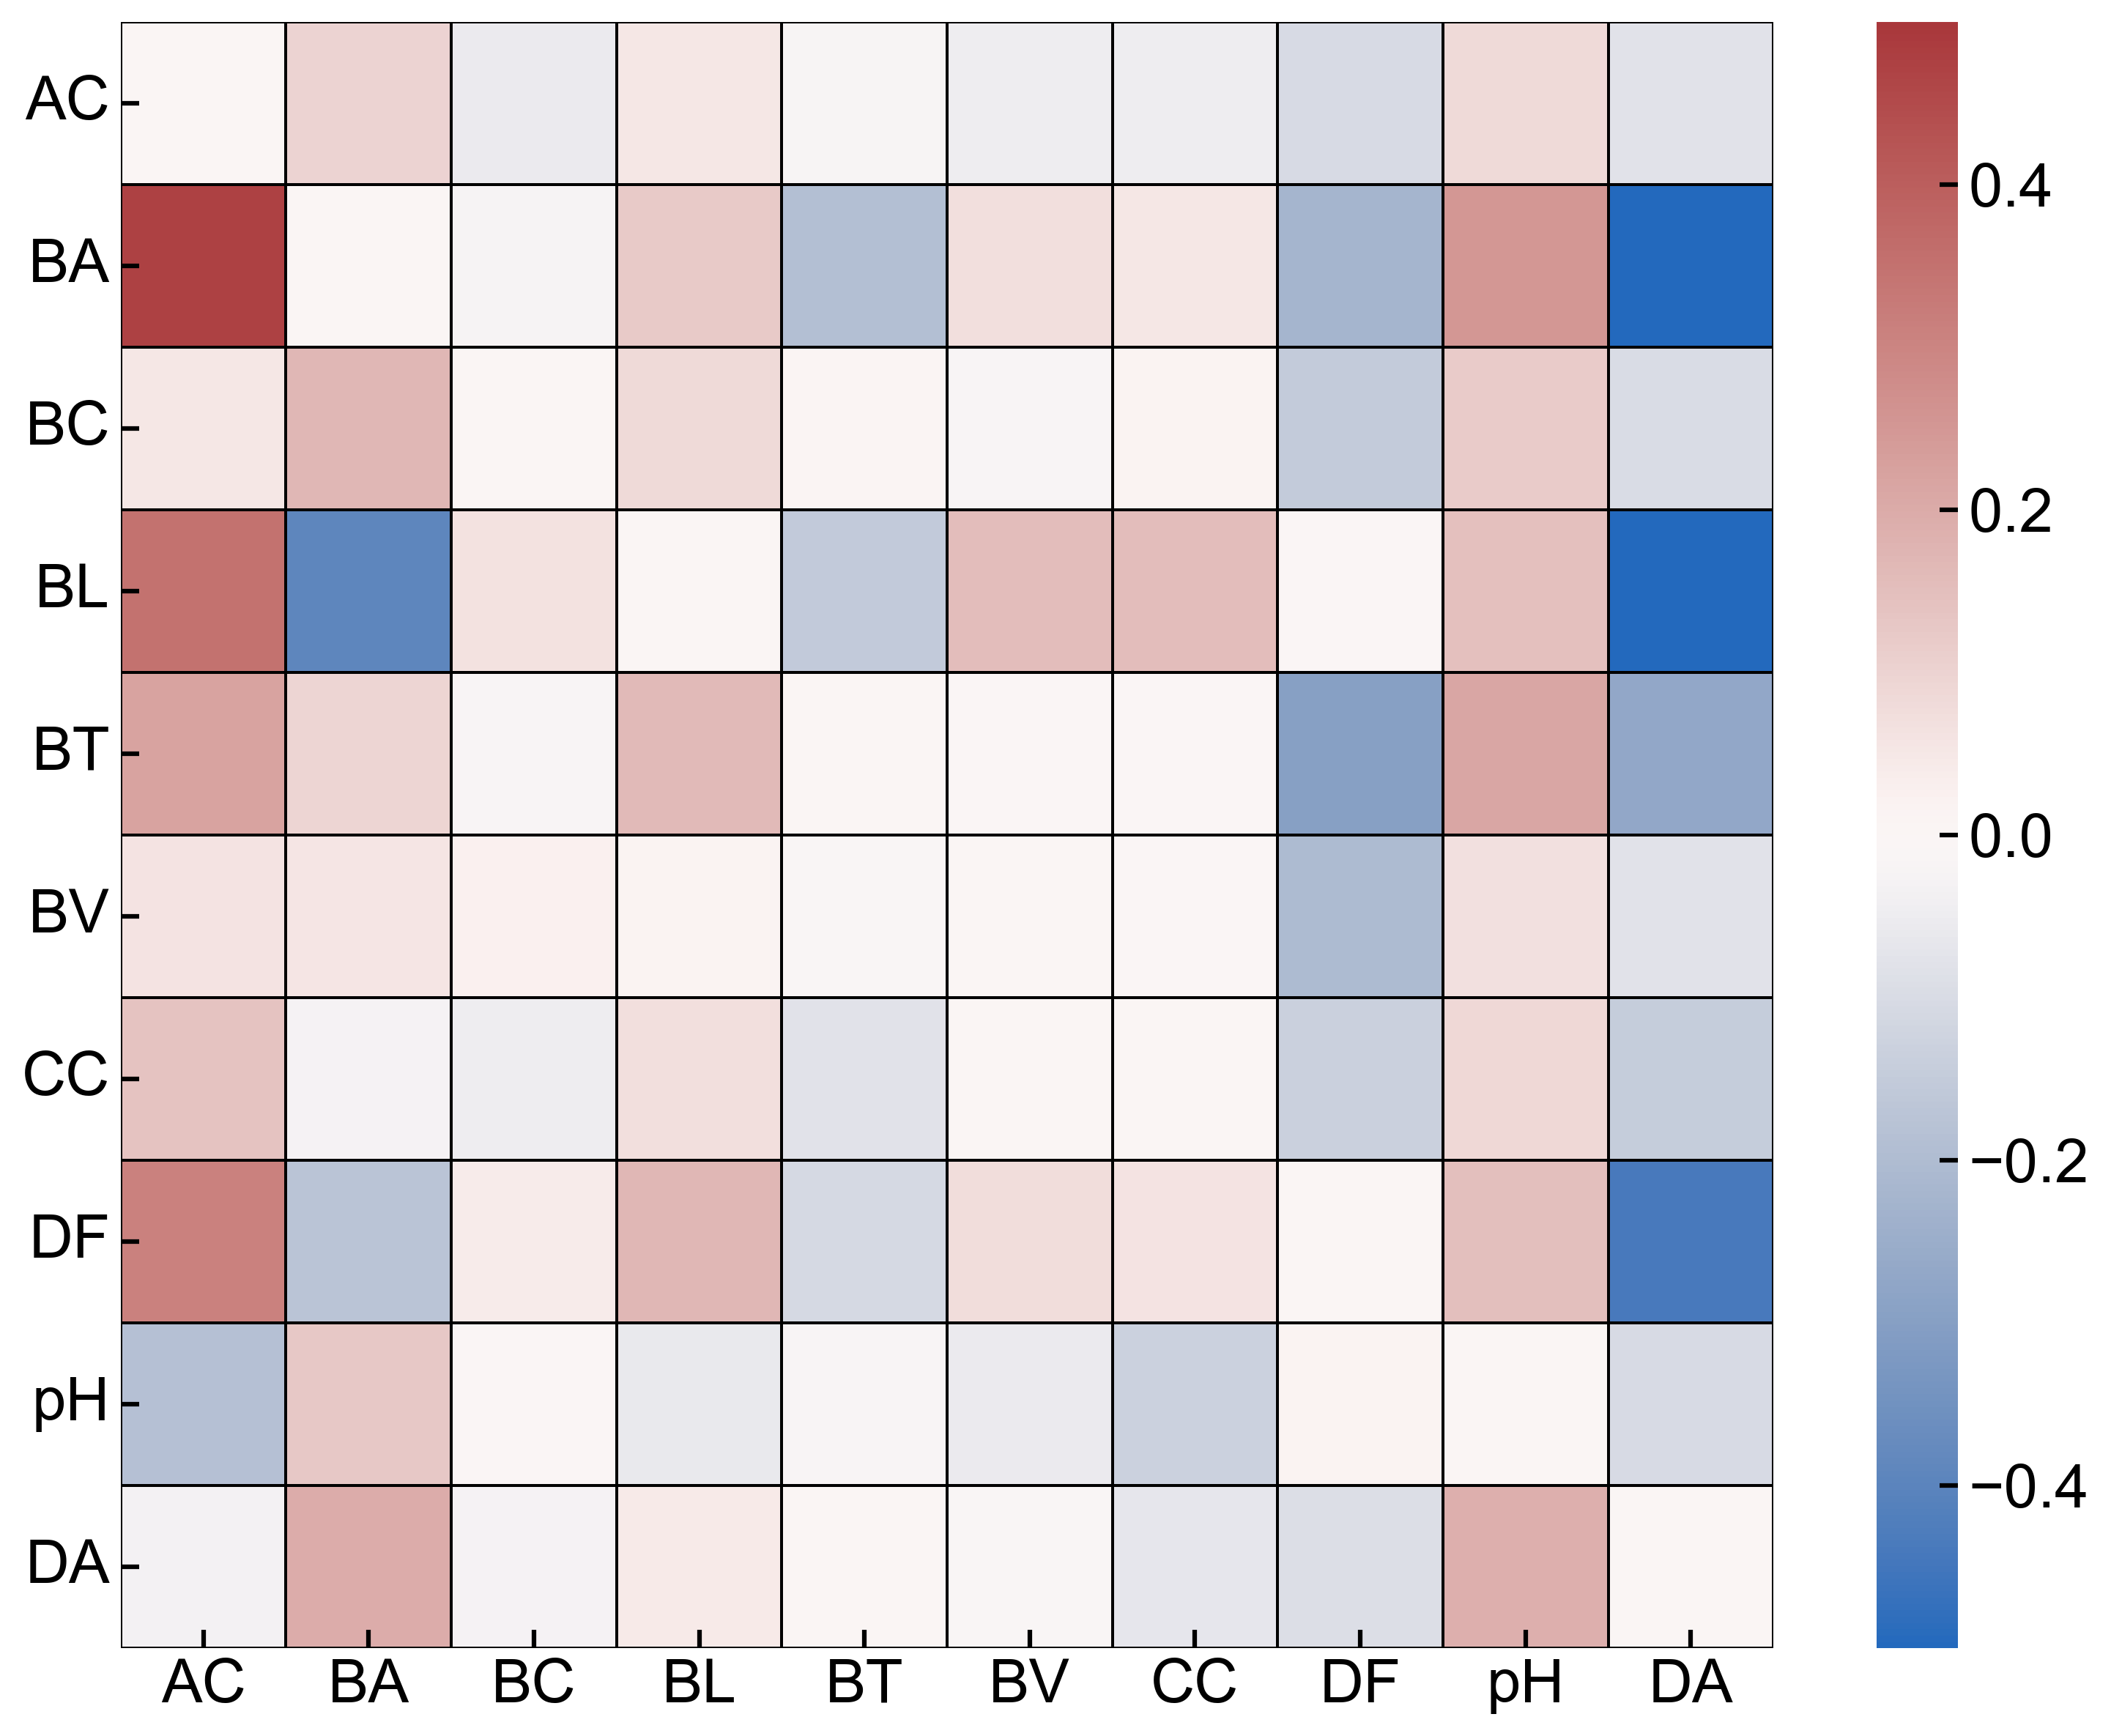

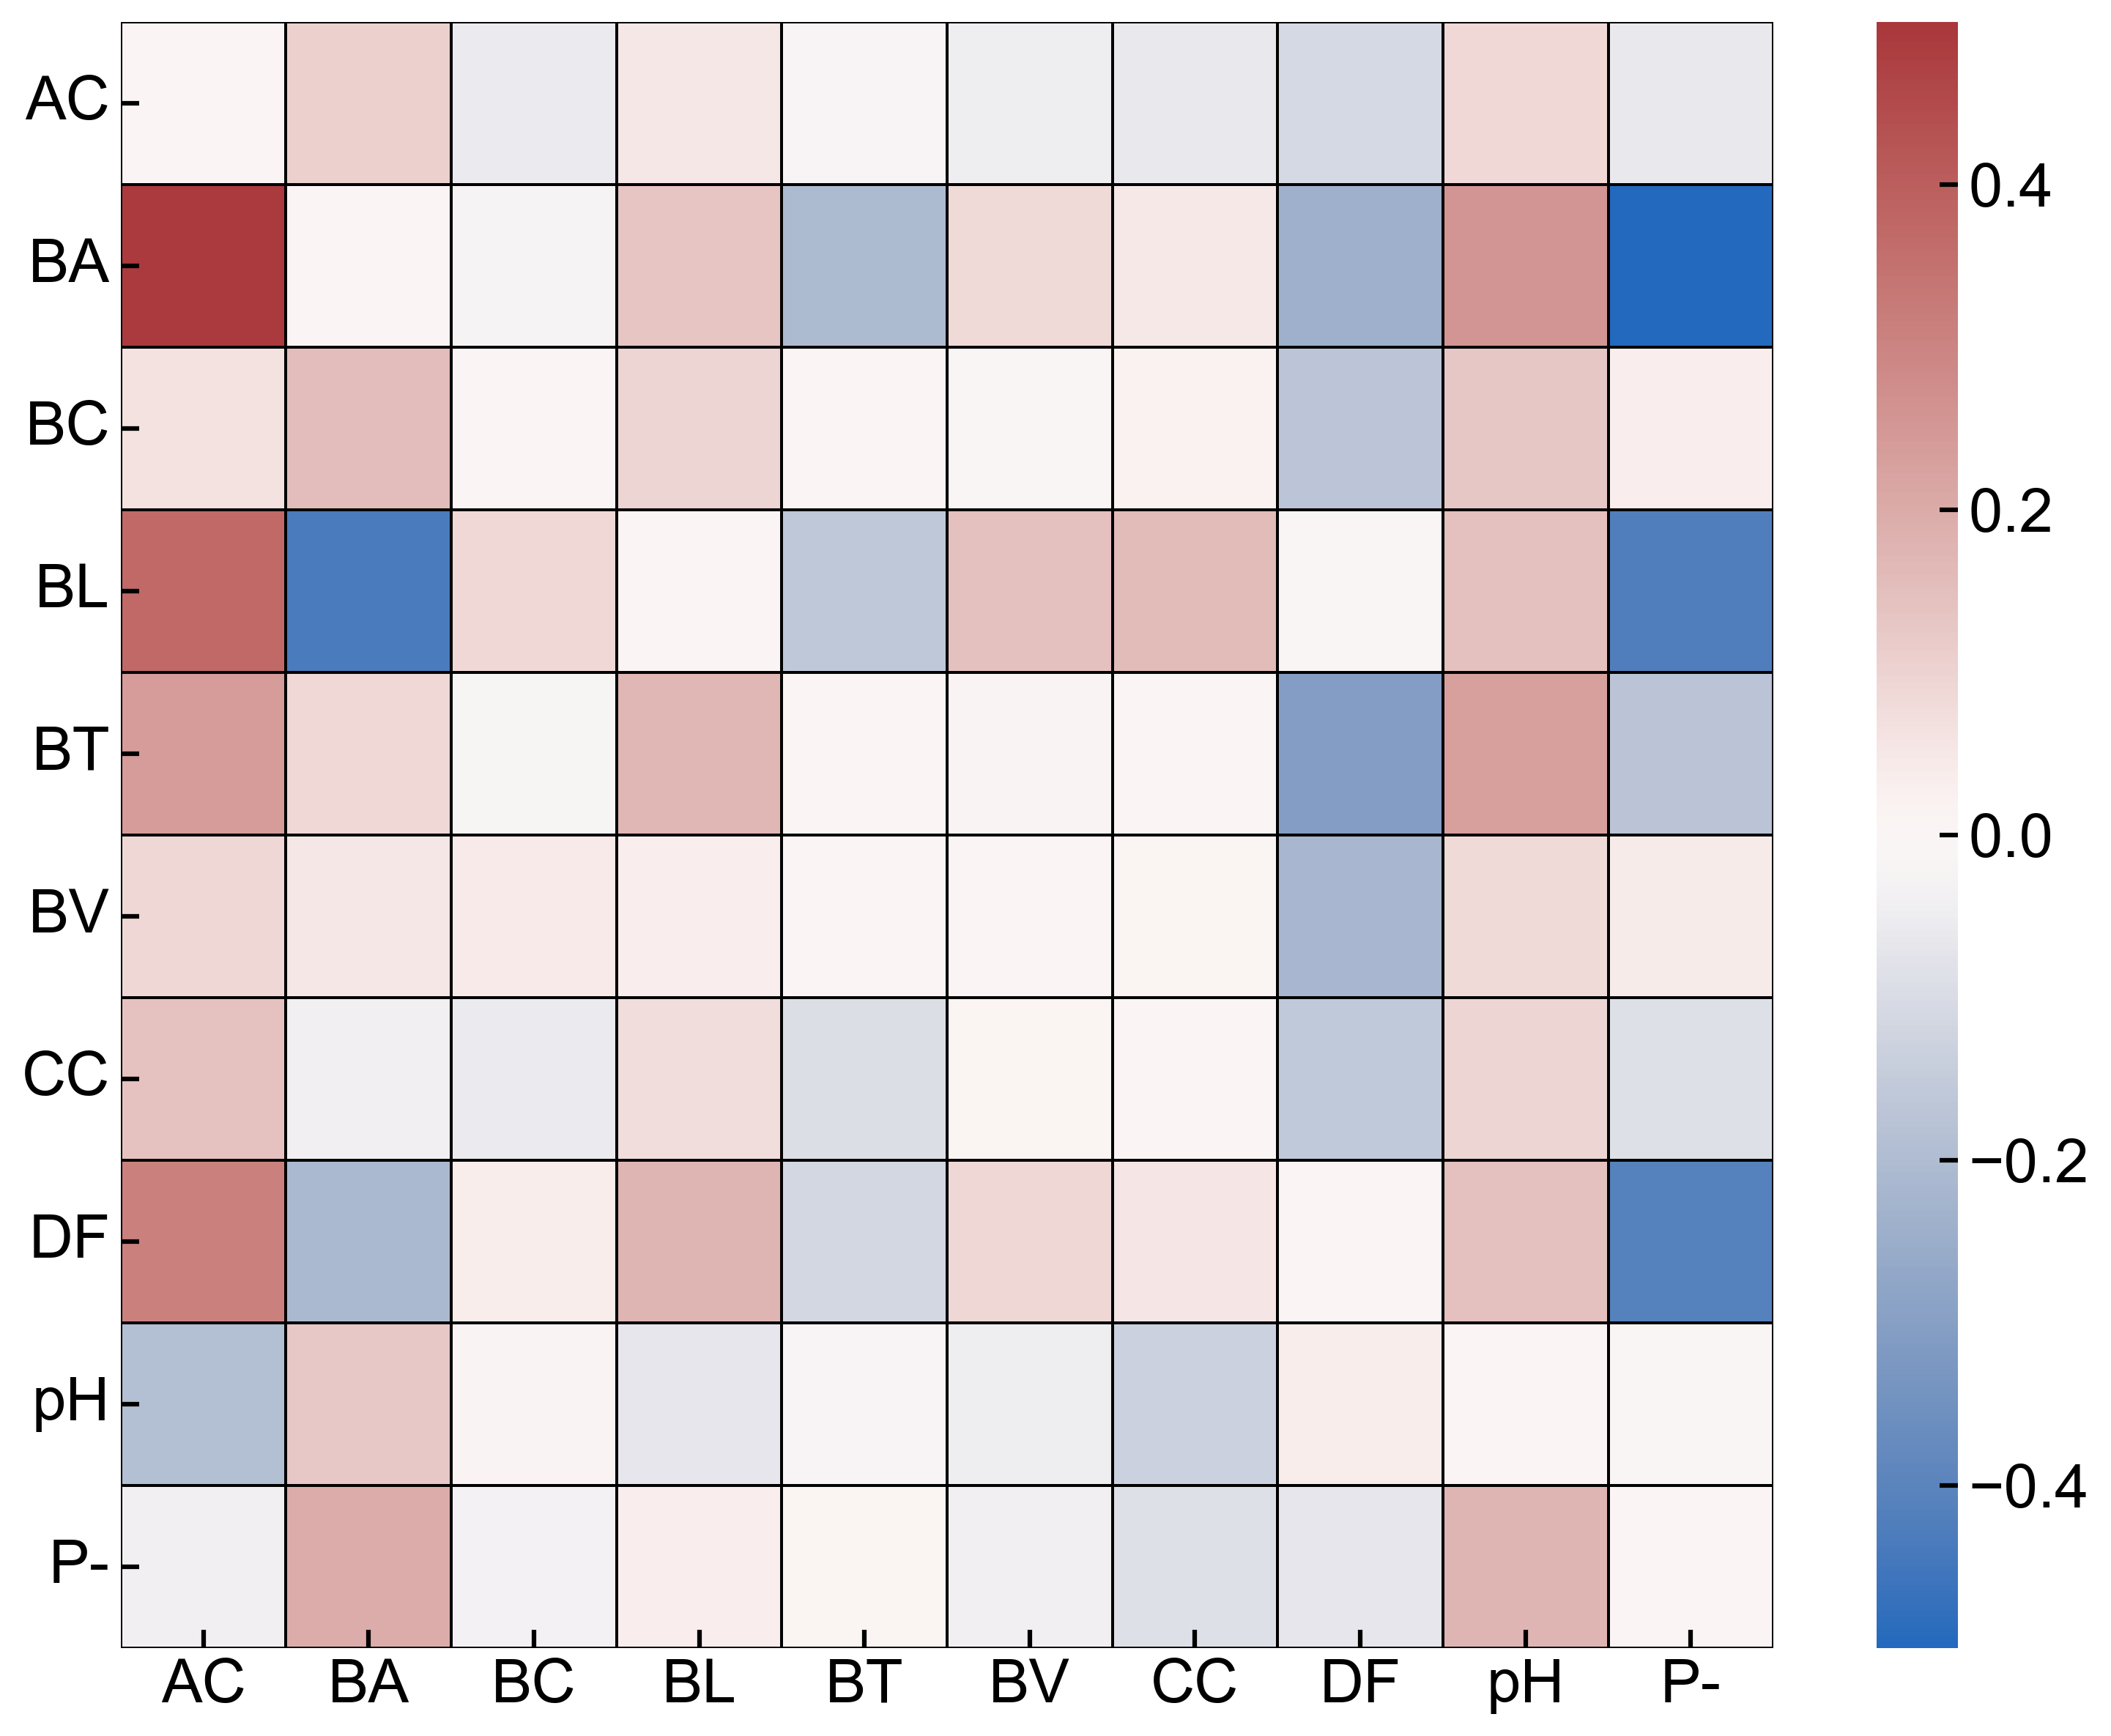

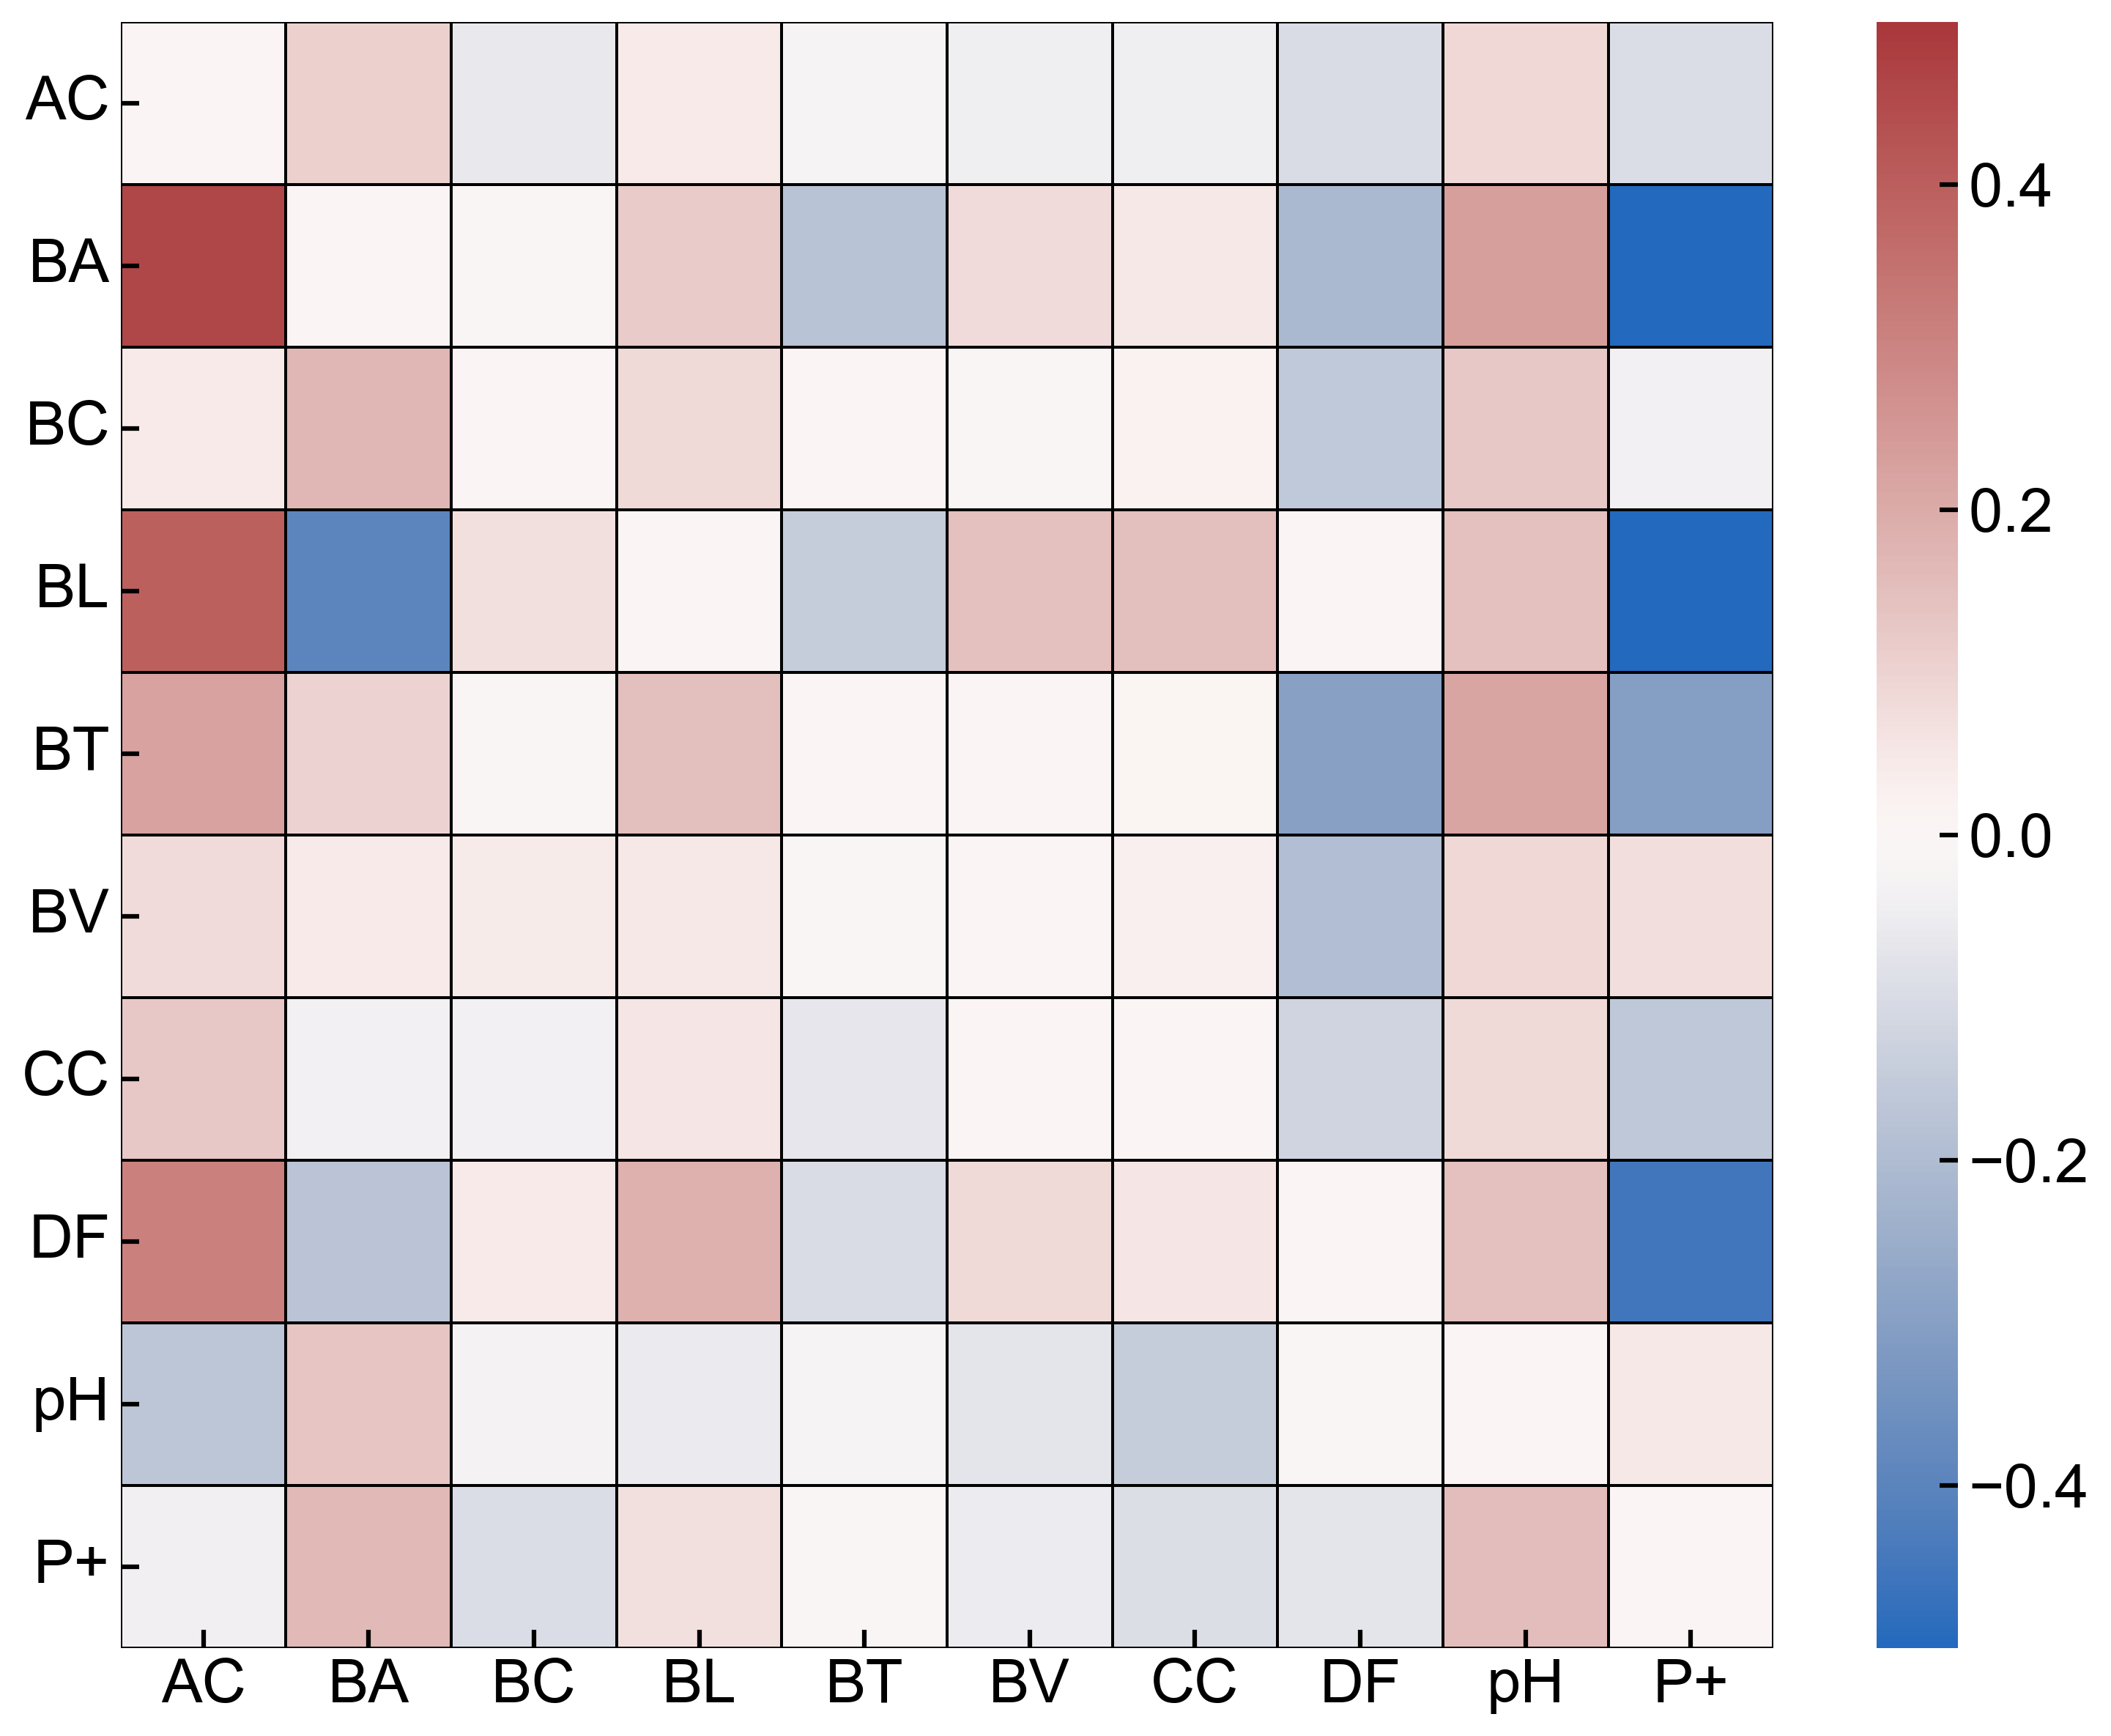

In [6]:
# species that aren't ecoli
not_ecoli = ['AC_OD', 'BA_OD', 'BC_OD', 'BL_OD', 'BT_OD', 'BV_OD', 'CC_OD', 'DF_OD', 'pH']

# set of ecoli strains
ecoli_strains =  ['wt_OD', 'delarc_OD', 'parc-_OD', 'parc+_OD']

# min and max (scaled) pH
pH_min = .3
pH_max = .7

shap_mean=[]

# loop over ecoli strains
for ecoli_strain in ecoli_strains:

    # species + single ecoli strain
    species_and_strain = not_ecoli + [ecoli_strain]

    # init network btw species and pH
    S2S = np.zeros([len(species_and_strain), len(species_and_strain)])
    
    # loop over receiver strains
    for i, receiver in enumerate(species_and_strain):
    
        # import SHAP values 
        int_df = pd.read_csv(f"insights/{ecoli_strain}/{receiver}_shap.csv")
        
        # consider nominal pH conditions
        pH_vals = int_df['pH'].values
        pH_inds = (pH_min < pH_vals) & (pH_vals < pH_max)
        int_df = int_df.iloc[pH_inds].copy()
        
        # loop over effector strains
        for j, effector in enumerate(species_and_strain):
            
            # keep self interactions equal to zero
            if j != i:

                # only consider samples with both receiver and effector species present
                receiver_design = int_df[receiver].values
                effector_design = int_df[effector].values
                interaction = int_df[f"{receiver}<--{effector}"].values[(receiver_design>0) & (effector_design>0)]

                # save average interaction
                S2S[i,j] = np.mean(interaction)
    
    #record shap means
    shap_mean.append(S2S)
    
    # remove underscore from labels
    labels = [s.split("_")[0] for s in species_and_strain]
    
    # set label of ecoli strain to standardize plot size
    if ecoli_strain == 'wt_OD':
        labels[-1] = 'WT'
    if ecoli_strain == 'delarc_OD':
        labels[-1] = 'DA'
    if ecoli_strain == 'parc-_OD':
        labels[-1] = 'P-'
    if ecoli_strain == 'parc+_OD':
        labels[-1] = 'P+'
        
    # seaborn heatmap
    sns.heatmap(S2S, 
                xticklabels=labels,
                yticklabels=labels,
                cmap='vlag', 
                vmin=-0.5,
                vmax=0.5,
                center=0.,
                linewidths=0.5, linecolor='black')

    plt.tight_layout()
    plt.xticks(rotation=0)
    plt.yticks(rotation=0)
    #plt.savefig(f"Figures/heatmaps/{ecoli_strain}_heatmap.svg", dpi=300)
    plt.show()

<Axes: >

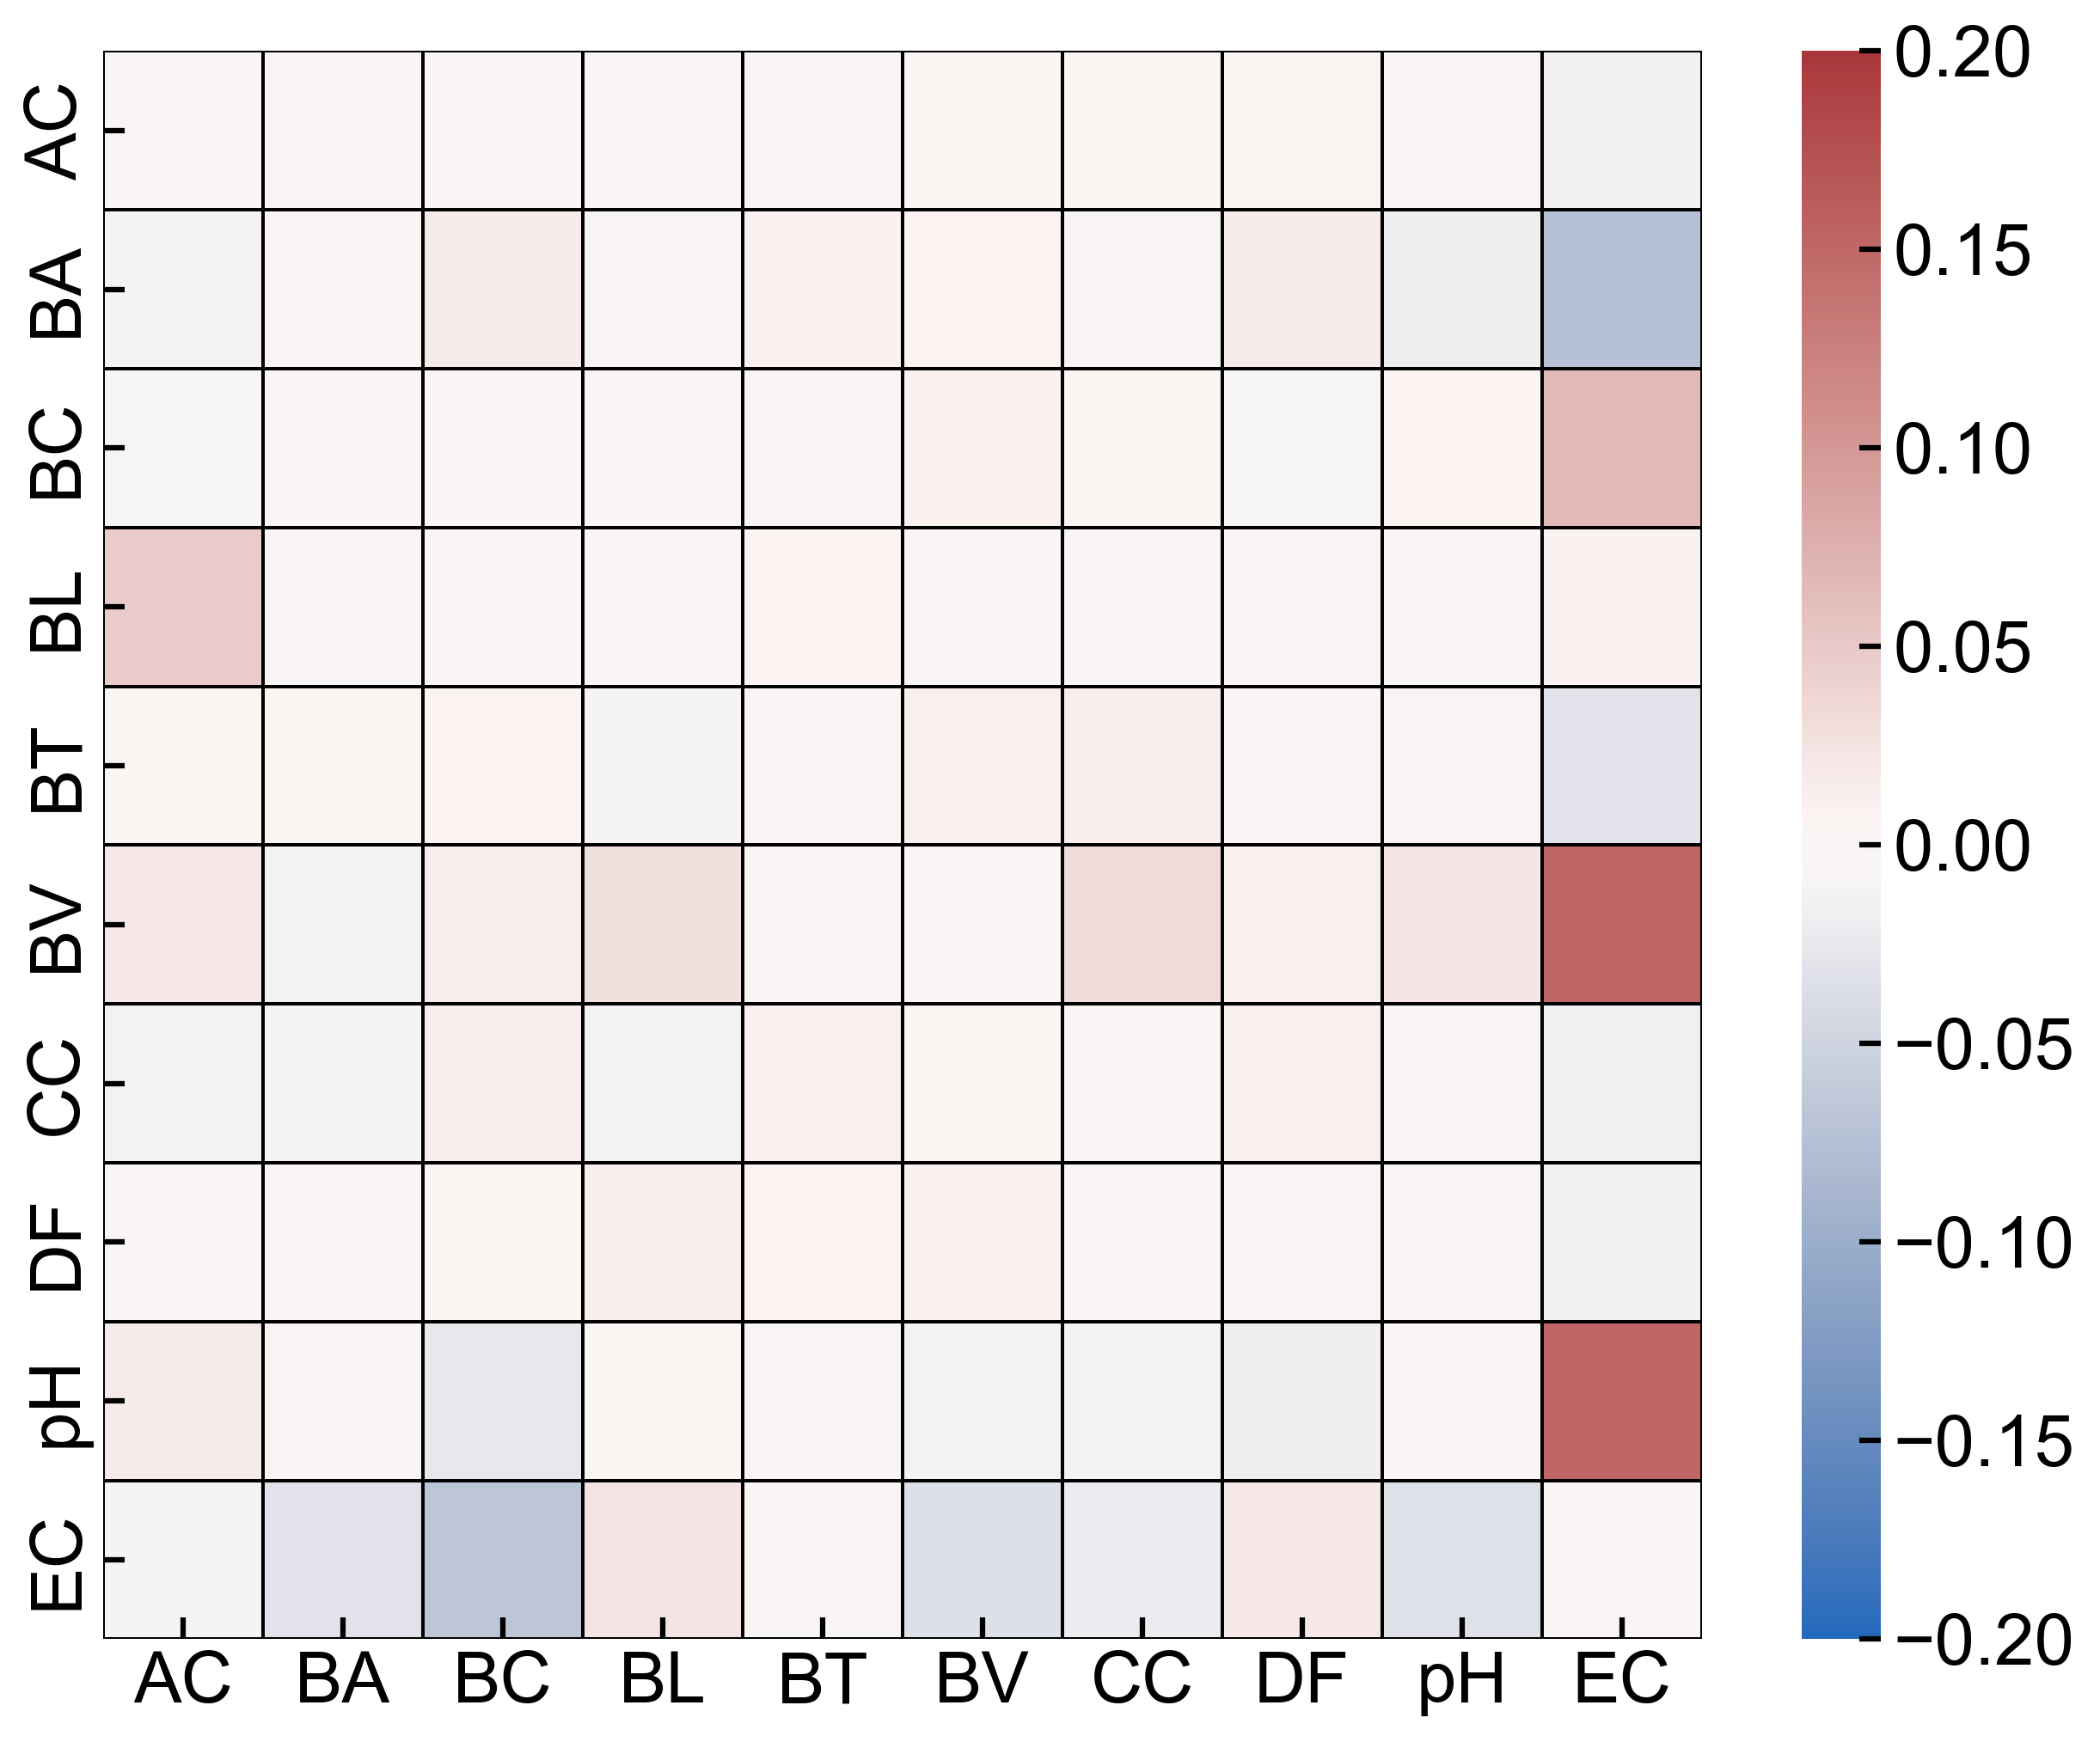

In [7]:
#calculate shap mean difference between parc+ and delarc

shap_diff = np.zeros([len(species_and_strain), len(species_and_strain)])

for i, receiver in enumerate(species_and_strain):
    for j, effector in enumerate(species_and_strain):
        shap_diff[i,j] = (shap_mean[3][i,j]+0.01)-(shap_mean[1][i,j]+0.01)

labels[-1] = 'EC'
sns.heatmap(shap_diff, 
                xticklabels=labels,
                yticklabels=labels,
                cmap='vlag', 
                vmin=-0.2,
                vmax=0.2,
                center=0.,
                linewidths=0.5, linecolor='black')

#plt.savefig(f"Figures/heatmaps/shap_heatmap.svg", dpi=300)

In [8]:
# define node colors
colordict = {
        'BA':'teal',
        'BL':'olive',
        'BC':'chocolate',
        'BT':'orchid',
        'BV':'indigo',
        'AC':'royalblue',
        'CC':'forestgreen',
        'DF':'orange',
        'EC':'firebrick',
        'pH':(0.8,0.8,0.8),
        }

allspeciesEC = ['AC','BA','BC','BL','BT','BV','CC','DF','pH','EC']

num_species = len(allspeciesEC)
node_color_vec = []

for i in range(num_species):
    node_color_vec.append(colordict[allspeciesEC[i]])


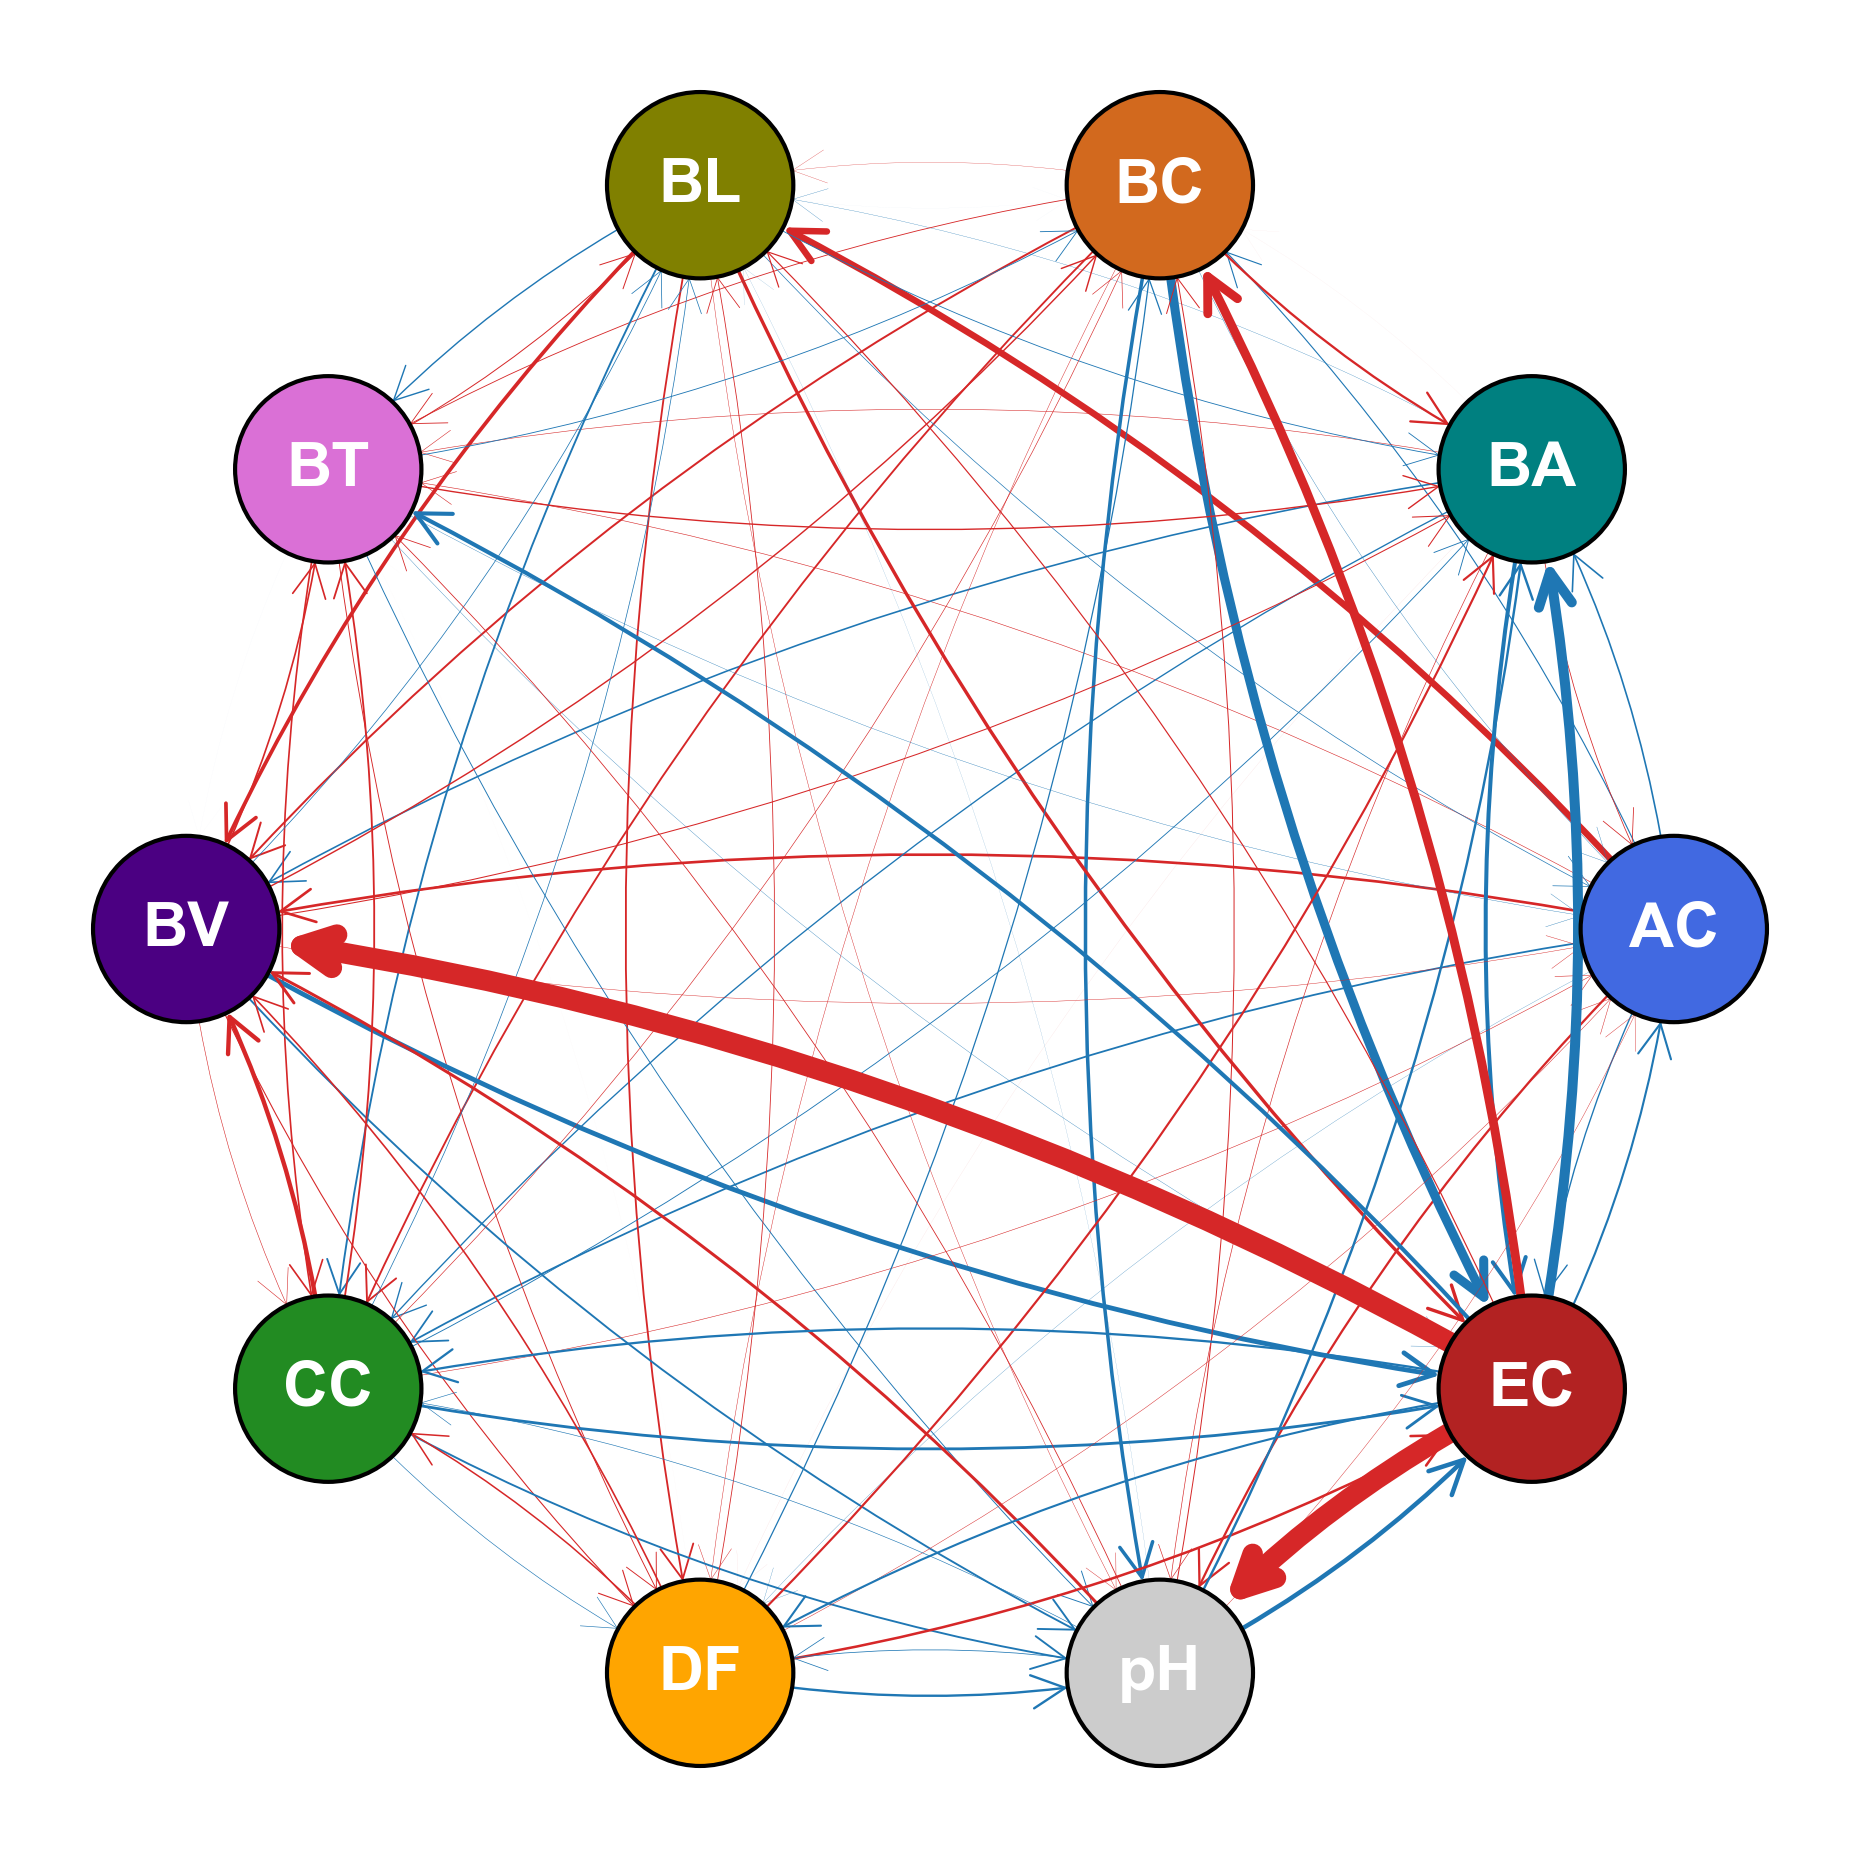

In [12]:
# shap difference network

# Create a directed graph
G = nx.DiGraph()

# add nodes
s_names = [s.split("_")[0] for s in species_and_strain]
s_names[-1] = 'EC'
G.add_nodes_from(s_names)

# min required magnitude to show edge
edge_min = 0 #.04

# Add edges connecting species to species
for i, receiver in enumerate(s_names):
    for j, effector in enumerate(s_names):
        if i != j:
            if np.abs(shap_diff[i, j]) > edge_min:
                if shap_diff[i, j] > 0:
                    G.add_edge(effector, receiver, width=abs(shap_diff[i, j]), color='tab:red')
                else:
                    G.add_edge(effector, receiver, width=abs(shap_diff[i, j]), color='tab:blue')

# Draw the graph with labeled nodes and edges
pos = nx.circular_layout(G)

# Get edge weights for drawing edge widths
edge_max = max([abs(G[u][v]['width']) for (u, v) in G.edges()])
edge_min = 0 #min([abs(G[u][v]['width']) for (u, v) in G.edges()])

# set edge widths, node sizes, and arrow sizes
edge_set_max = 5
edge_set_min = 0
widths = [(G[u][v]['width'] - edge_min) / (edge_max - edge_min) * (edge_set_max - edge_set_min) + edge_set_min
          for (u, v) in G.edges()]

# Draw the network graph
plt.figure(figsize=(6, 6))
nx.draw(G, pos, 
        with_labels=True, 
        node_size=2000, 
        node_color = node_color_vec,
        edgecolors='black',
        font_size=15, 
        font_weight='bold',
        font_color='white', 
        arrowsize=20, 
        connectionstyle='arc3, rad=.1',
        arrowstyle='->',
        width=widths, 
        min_source_margin=10,
        edge_color=[G[u][v]['color'] for u, v in G.edges()],
        edge_cmap=plt.cm.Greys)
plt.axis('off')

#plt.savefig(f"figures/heatmaps/shapdiff_network.svg", dpi=300)
plt.show()